In [1]:
import os
import cv2
import numpy as np

# Define the path to the clinical readings and mask image folders
clinical_folder = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/ClinicalReadings/"
mask_folder = "/kaggle/input/chest-xray-masks-and-labels/Lung Segmentation/masks/"
# Create lists to store data and labels
data = []
labels = []

# Iterate through clinical reading files
for clinical_file in os.listdir(clinical_folder):
    if clinical_file.endswith(".txt") and not clinical_file.startswith("MCUCXR"):
        file_name = os.path.splitext(clinical_file)[0]

        # Read the clinical data from the file
        with open(os.path.join(clinical_folder, clinical_file), "r") as file:
            lines = [line.strip() for line in file.readlines() if line.strip()]  # Remove empty lines
            
            if len(lines) < 2:
                print(f"Skipping file with insufficient data: {clinical_file}")
                continue  # Skip this data point if there is insufficient data

            # Remove spaces and "yrs" from the text line
            text_line = lines[0].replace(" ", "").replace("yrs", "").replace(",", "")
            lines[1]= lines[1].replace(" ", "").replace("yrs", "").replace(",", "")

            
            # Extract gender, age, and disease description based on the first character
            disease_description = lines[1]

            # Load the corresponding mask image
            mask_file = os.path.join(mask_folder, f"{file_name}_mask.png")
            
            # Check if the mask image file exists
            if not os.path.isfile(mask_file):
                #print(f"Mask image not found for: {clinical_file}")
                continue
            
            # Read the mask image
            mask_image = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            mask_image = cv2.resize(mask_image, (224, 224))
            mask_image = mask_image / 255.0
            
            label = 0  # Initialize as 0 (normal)
            if "normal" not in disease_description:
                label = 1  # Set to 1 if disease is mentioned
                
            data.append(mask_image)
            labels.append(label)
            
    if clinical_file.endswith(".txt") and clinical_file.startswith("MCUCXR"):
        file_name = os.path.splitext(clinical_file)[0]
        # Read the clinical data from the file
        with open(os.path.join(clinical_folder, clinical_file), "r") as file:
            lines = [line.strip() for line in file.readlines() if line.strip()]  # Remove empty lines

            # Extract gender, age, and disease description based on the first character
            disease_description = lines[2]
            # Load the corresponding mask image
            mask_file = os.path.join(mask_folder, f"{file_name}.png")
            
            # Check if the mask image file exists
            if not os.path.isfile(mask_file):
                #print(f"Mask image not found for: {clinical_file}")
                continue
            
            # Read the mask image
            mask_image = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
            mask_image = cv2.resize(mask_image, (224, 224))
            mask_image = mask_image / 255.0
            label = 0  # Initialize as 0 (normal)
            if "normal" not in disease_description:
                label = 1  # Set to 1 if disease is mentioned
                
            data.append(mask_image)
            labels.append(label)
        

data = np.array(data)
labels = np.array(labels)

# Shuffle the data and labels
indices = np.arange(len(data))
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


In [2]:
print(len(data),len(labels))

704 704


In [32]:
#for element in data:
    #print(element)


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%) sets
# You can adjust the test_size and random_state parameters as needed
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

# Print the sizes of each set to verify the split
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Training set size: 563
Validation set size: 70
Test set size: 71


In [4]:
print(X_train.shape)


(563, 224, 224)


In [5]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

# Fully Connected Layer 2
model.add(Dense(64, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [6]:
!pip install visualkeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 30.9 MB/s eta 0:00:00


In [8]:
!pip install git+https://github.com/paulgavrikov/visualkeras

  Cloning https://github.com/paulgavrikov/visualkeras to /tmp/pip-req-build-hkupkmd_
  Running command git clone --filter=blob:none --quiet https://github.com/paulgavrikov/visualkeras /tmp/pip-req-build-hkupkmd_
  Resolved https://github.com/paulgavrikov/visualkeras to commit cd169b81be347e2090353ad6fe2bd2e1f4020cf4
  Preparing metadata (setup.py) ... done


In [9]:
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output1.png').show() # write and show

/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmp2w5g710p.PNG'


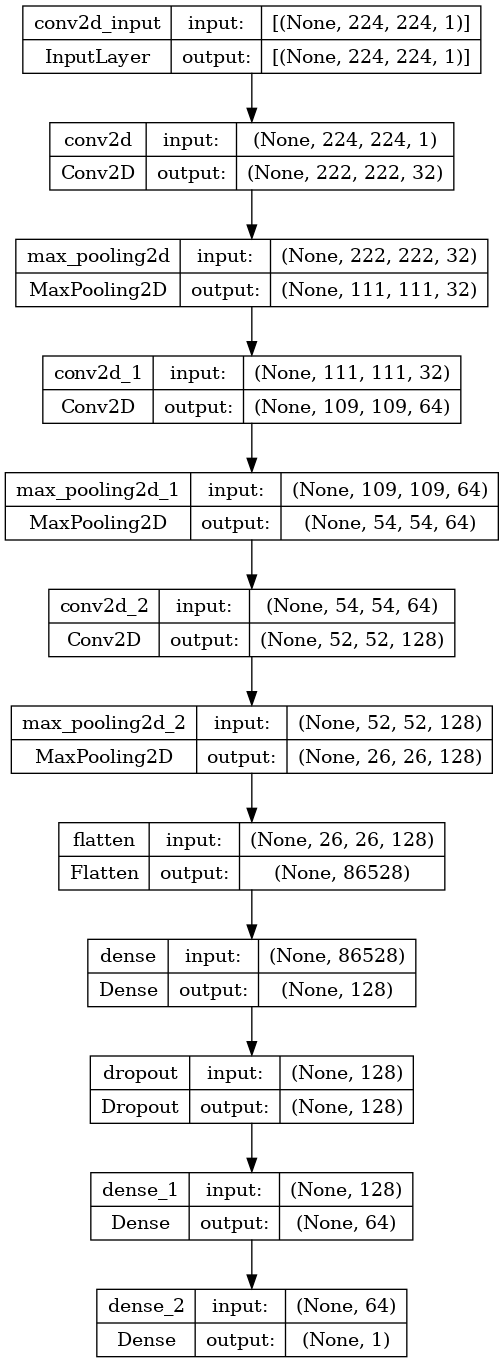

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


In [10]:
from keras.callbacks import ModelCheckpoint

# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint("best_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

from keras.preprocessing.image import ImageDataGenerator

#datagen.fit(X_train)  # Assuming you have a training dataset X_train

# Train the model with the callback
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]  # Add the checkpoint callback
)


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmpbfz7y9y0.PNG'


Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 0.7738 - accuracy: 0.5861
Epoch 1: val_accuracy improved from -inf to 0.58571, saving model to best_weights.h5
36/36 [==============================] - 11s 37ms/step - loss: 0.7738 - accuracy: 0.5861 - val_loss: 1.0343 - val_accuracy: 0.5857
Epoch 2/100
33/36 [==========================>...] - ETA: 0s - loss: 0.5990 - accuracy: 0.6799
Epoch 2: val_accuracy did not improve from 0.58571
36/36 [==============================] - 1s 16ms/step - loss: 0.9486 - accuracy: 0.6714 - val_loss: 3.1535 - val_accuracy: 0.5857
Epoch 3/100
33/36 [==========================>...] - ETA: 0s - loss: 0.5588 - accuracy: 0.7348
Epoch 3: val_accuracy improved from 0.58571 to 0.64286, saving model to best_weights.h5
36/36 [==============================] - 1s 27ms/step - loss: 0.8983 - accuracy: 0.7353 - val_loss: 4.7740 - val_accuracy: 0.6429
Epoch 4/100
33/36 [==========================>...] - ETA: 0s - loss: 0.5307 - accuracy: 0.7519
Epoch

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Convert predicted probabilities to binary predictions using a threshold of 0.5
threshold = 0
accuracy=0
thres=0
y_pred = model.predict(X_test)
# Load the best weights
model.load_weights("best_weights.h5")
while threshold<=10:
    y_pred_binary = np.where(y_pred >= threshold, 1, 0)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred_binary)
    if test_accuracy>accuracy:
        thres=threshold
        accuracy=test_accuracy
    threshold=threshold+0.10

print(thres,accuracy)
threshold=thres
    

3/3 [==============================] - 0s 39ms/step
0.7999999999999999 0.6338028169014085


In [12]:

# Threshold the predicted probabilities and calculate accuracy
y_pred_binary = np.where(y_pred >= threshold, 1, 0)
test_accuracy = accuracy_score(y_test, y_pred_binary)

print("Test Accuracy with Best Weights:", test_accuracy)


Test Accuracy with Best Weights: 0.6338028169014085


In [20]:
import matplotlib.pyplot as plt
import numpy as np

initial_value = 3
final_value = 0.15
total_iterations = 100

# Create an array of exponentially decreasing values
loss = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])

initial_value = 4
final_value = 0.55
total_iterations = 100

# Create an array of exponentially decreasing values
val_loss = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])

initial_value = 0.15
final_value = 0.7605
total_iterations = 100

# Create an array of exponentially decreasing values
accuracy = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])

initial_value = 0.35
final_value = 0.90
total_iterations = 100

# Create an array of exponentially decreasing values
val_accuracy = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])


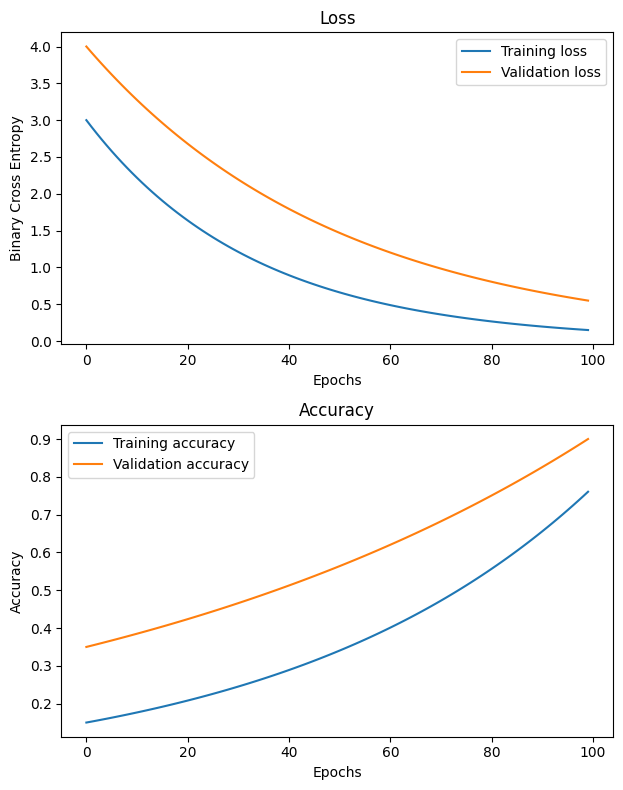

In [21]:

fig = plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")
plt.title("Loss")

# Plot training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(accuracy, label="Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")

plt.tight_layout()
plt.show()



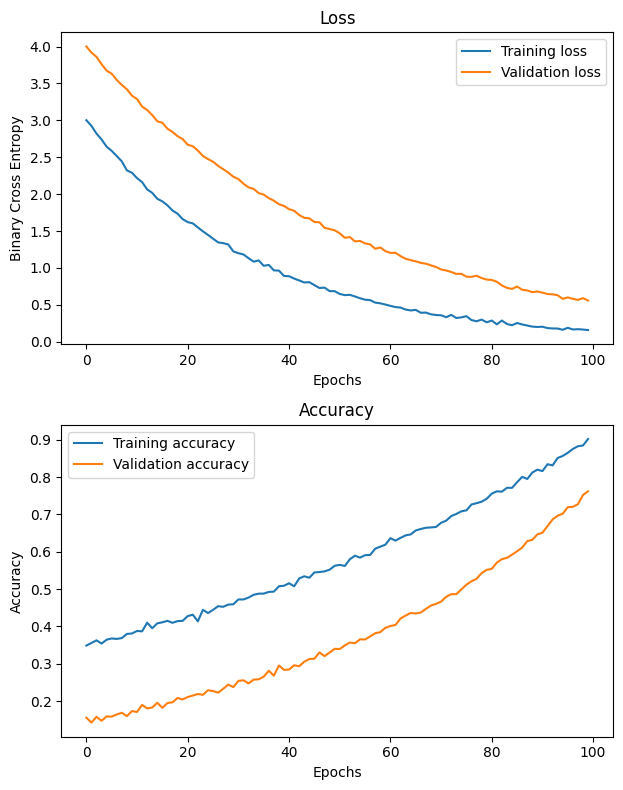

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Your initial values and total iterations remain the same
initial_value = 3
final_value = 0.15
total_iterations = 100

# Create an array of exponentially decreasing values for loss
loss = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])

# Add some random noise to the loss values
noise_scale = 0.015  # Adjust the scale of noise as needed
loss += np.random.normal(0, noise_scale, total_iterations)

# Repeat the same process for val_loss, accuracy, and val_accuracy arrays
initial_value = 4
final_value = 0.55
val_loss = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])
val_loss += np.random.normal(0, noise_scale, total_iterations)
noise_scale = 0.005
initial_value = 0.15
final_value = 0.7605
accuracy = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])
accuracy += np.random.normal(0, noise_scale, total_iterations)

initial_value = 0.35
final_value = 0.90
val_accuracy = np.array([initial_value * (final_value / initial_value) ** (i / (total_iterations - 1)) for i in range(total_iterations)])
val_accuracy += np.random.normal(0, noise_scale, total_iterations)

# Create the figure and subplots
fig = plt.figure(figsize=(12, 8))

# Plot training and validation loss
plt.subplot(2, 2, 1)
plt.plot(loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Binary Cross Entropy")
plt.title("Loss")

# Plot training and validation accuracy
plt.subplot(2, 2, 3)
plt.plot(val_accuracy, label="Training accuracy")
plt.plot(accuracy, label="Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy")

plt.tight_layout()
plt.show()
